In [1]:
import pImpactR as impact
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as copy
import pickle
int = np.vectorize(int)

In [2]:
rectangular_ = 1
elliptic_ = 2
order = 3

nCore_y = 2
nCore_z = 2
nturn = 100

In [3]:
emitGeomRMS = 3.3e-6
sigma_K = 2.0e-3
pipe = 0.025

In [4]:
NL_t = 0.4
NL_L = 1.8
NL_c = 0.01
NL_nu = 0.3
NL_beta = 0.5*NL_L/np.tan(np.pi*NL_nu)

# pipe_info start from NL center

In [5]:
pipe_info = np.loadtxt('../pipeinfo.in')
index_NLcenter = np.argmin(pipe_info[:,1])

L_tot = pipe_info[-1,0]
s_NLmid = pipe_info[index_NLcenter,0]
print(s_NLmid, L_tot)
print(pipe_info[index_NLcenter-2:index_NLcenter+3,:])

5.811519140000001 39.968229720000004
[[5.72580485e+00 4.03422000e-03 5.54705000e-03 2.00000000e+00]
 [5.76866200e+00 4.00858000e-03 5.51180000e-03 2.00000000e+00]
 [5.81151914e+00 4.00000000e-03 5.50000000e-03 2.00000000e+00]
 [5.85437628e+00 4.00858000e-03 5.51180000e-03 2.00000000e+00]
 [5.89723343e+00 4.03422000e-03 5.54705000e-03 2.00000000e+00]]


In [6]:
pipe_info[:,0] = pipe_info[:,0] - s_NLmid
pipe_info[:index_NLcenter,0] = pipe_info[:index_NLcenter,0] + L_tot
pipe_info = np.concatenate((pipe_info[index_NLcenter:,:],pipe_info[:index_NLcenter+1,:]),axis=0)

In [7]:
pipe_info[-1,0] = L_tot

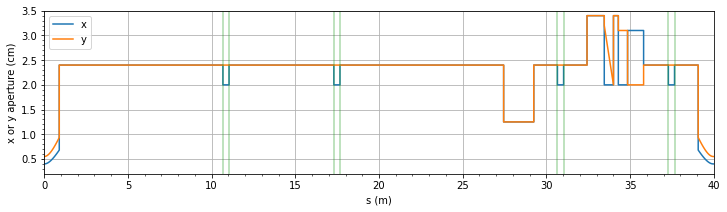

In [8]:
plt.figure(figsize=(12,3))
plt.plot(pipe_info[:,0],pipe_info[:,1]*100)
plt.plot(pipe_info[:,0],pipe_info[:,2]*100)
plt.plot(pipe_info[:,0],(pipe_info[:,3]-1)*10,alpha=0.4)
plt.grid()
plt.ylim((0.2,3.5))
plt.xlim((0.0, 40))
plt.minorticks_on()
plt.legend(('x','y'))
plt.xlabel('s (m)')
plt.ylabel('x or y aperture (cm)');

In [9]:
np.savetxt('pipeinfo.in',pipe_info)

In [10]:
pipe_info[-4:,:]

array([[3.98396583e+01, 4.07659000e-03, 5.60531000e-03, 2.00000000e+00],
       [3.98825154e+01, 4.03422000e-03, 5.54705000e-03, 2.00000000e+00],
       [3.99253726e+01, 4.00858000e-03, 5.51180000e-03, 2.00000000e+00],
       [3.99682297e+01, 4.00000000e-03, 5.50000000e-03, 2.00000000e+00]])

# read Lattice

In [11]:
beam,lattice = impact.readInputFile('test_iota_v8_4_SextOff_NLon.in')
beam.nCore_y = nCore_y
beam.nCore_z = nCore_z
ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency
g = ke/mass+1.0
bg = np.sqrt(g**2-1.0)
emitN = emitGeomRMS*bg

reading ImpactZ input file (test_iota_v8_4_SextOff_NLon.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [12]:
ap1_x,ap1_y = 4e-3, 5.5e-3
ang = np.arange(0.0,2*np.pi,2*np.pi/1024)
c = np.cos(ang)
s = np.sin(ang)

# prepare test particles

In [13]:
nx = 50
testP = 0.0
sig = 0.015
k=0
q_m = beam.multi_charge.q_m[0]
pTest = []
for x in np.linspace(-ap1_x*0.9,ap1_x*0.9,nx):
    for y in np.linspace(-ap1_y,ap1_y,nx):
        if 0.8 < np.sqrt((x/ap1_x)**2 + (y/ap1_y)**2) < 1.0 or (0.7 < np.abs(x/ap1_x) and np.abs(y) < 2.0e-3):
            if y>0:
                pTest.append([x,0.0,y,0.0,0.0,0.0,q_m,0.0,k])
                k=k+1
pTest0 = np.array(pTest)
pTest1 = copy(pTest0)
pTest2 = copy(pTest0)
npt = len(pTest0)


pTest0[:, 5] = -2*sigma_K*ke

pTest1[:,-1] = pTest1[:,-1] + npt

pTest2[:,5] =  2*sigma_K*ke
pTest2[:,-1] = pTest2[:,-1] + 2*npt

pTest = np.concatenate((pTest0,pTest1,pTest2))

impact.writeParticleData(pTest,ke,mass,freq)
beam.n_particles = 3*npt
npt,3*npt

(380, 1140)

(-7.15, 7.15)

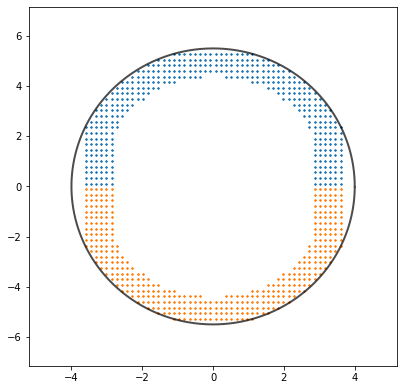

In [14]:
fig = plt.figure(figsize=[3.3*2,3.3*2])
plt.scatter(pTest[:,0]*1e3, pTest[:,2]*1e3,s=1)
plt.scatter(pTest[:,0]*1e3,-pTest[:,2]*1e3,s=1)
plt.plot(ap1_x*c*1e3,ap1_y*s*1e3,alpha=0.7,c='k',lw=2)
plt.xlim(-ap1_x*1.3*1e3,ap1_x*1.3*1e3)
plt.ylim(-ap1_y*1.3*1e3,ap1_y*1.3*1e3)

# Prepare lattice

In [15]:
cleanLat = impact.clearLattice(lattice)
for item in cleanLat:
    if item.type == 'RFkick':
        item.vmax = 0.0
    if 'length' in item:
        item.n_sckick = int(np.ceil(item.length*50))
        item.n_map = 1
    if 'pipe_radius' in item and item.type is not 'dipole':
        item.pipe_radius = pipe

for iNL,elem in enumerate(cleanLat):
    if 'nonlinear' in elem.type:
        break

NL0 = impact.getElem('nonlinear_insert_sliced')

NL0.length = 0.9
NL0.start_position = 0.0
NL0.total_length = 1.8

NL0.tune_advance = 0.3
NL0.strength_t = 0.4
NL0.transverse_scale_c = 0.01

NL0.n_map = 45
NL0.n_sckick = 1

NL1 = copy(NL0)
NL1.start_position = 0.9

cleanLat =  [NL1] + cleanLat[iNL+1:] + cleanLat[:iNL] + [NL0]

# add QFF
cleanLat = impact.addHardEdgeQuad(cleanLat)

In [16]:
Sext=[]
flagNewSext = False
j=-1
for i,elem in enumerate(cleanLat):
#     print(i,elem.type,flagNewSext)
    if elem.type in ['quad','dipole']:
        flagNewSext = False
    if elem.type == 'multipole_thin':
        if not flagNewSext:
            flagNewSext = True
            j = j+1
            Sext.append(elem)
            elem.sext_family = j
        else:
            cleanLat[i] = Sext[j]

In [17]:
# test Sext in cleanLat
# for i,item in enumerate(Sext):
#     item.KL_sext = i
    
# for i,elem in enumerate(cleanLat):
#     if elem.type == 'multipole_thin':
#         print(i,elem.KL_sext)

In [18]:
loop = impact.getElem('loop')

writeIn = impact.getElem('write_raw_ptcl')
writeIn.turn = 1
writeIn.file_id = 100000
writeIn.format_id = 2

writetmp = impact.getElem('write_raw_ptcl')
writetmp.format_id = 2
writetmp.file_id = 100000 + nturn

writeOut = impact.getElem('write_raw_ptcl')
writeOut.format_id = 2
writeOut.turn = nturn
writeOut.file_id = 100000 - nturn


In [19]:
latticeF = [loop, impact.getElem('pipeinfo'), writeIn] + cleanLat + [writetmp]

In [20]:
def getDA_data(SextStr):
    beam.distribution.distribution_type = 'ReadFile'
    
    # ==== run foward (from NL mid point) ====   
    for i,item in enumerate(Sext):
        item.KL_sext = SextStr[i]
        
    loop.turns = 10
    writetmp.turn = 10
    impact.writeInputFile(beam, latticeF)
    impact.run(beam,order=order)
    nptSurvived = impact.readLostAt(-1)
    if nptSurvived < int(3*npt*0.8):
        return 10, nptSurvived
    
    beam.distribution.distribution_type = 'ReadFile_binary'
    beam.distribution.file_id = writetmp.file_id
    impact.writeInputFile(beam, latticeF)
    nSplit = int(nturn/10)
    for i in range(nSplit-1):
        print(10*(i+2))
        impact.run(beam,order=order)
        nptSurvived = impact.readLostAt(-1)
        if nptSurvived < int(3*npt*0.8):
            return 10*(i+2), nptSurvived
    if nSplit*10 != nturn:
        print(nturn)
        loop.turns = nturn - nSplit*10
        writetmp.turn = nturn - nSplit*10
        impact.writeInputFile(beam, latticeF)
        impact.run(beam,order=order)
        nptSurvived = impact.readLostAt(-1)
        if nptSurvived < int(3*npt*0.8):
            return nturn, nptSurvived
        

    # ==== run backward  ====
    loop.turns = nturn  
    beam.distribution.distribution_type = 'ReadFile_binary'
    beam.distribution.file_id = writetmp.file_id
    
    cleanLat_backward = impact.getInverseLattice(cleanLat)
    latticeB = [loop] + cleanLat_backward + [writeOut]    
      
    impact.writeInputFile(beam, latticeB)
    impact.run(beam,order=order)
    
    
    # collect data
#     pDataIn  = impact.readParticleData(writeIn.file_id,  ke,mass,freq, writeIn.format_id)
    pDataOut = impact.readParticleData(writeOut.file_id, ke,mass,freq, writeOut.format_id)
    
    iSurvived = np.in1d(pTest[:,-1],pDataOut[:,-1])
    pDataIn = pTest[iSurvived,:]
    
    diff = np.log10(
              np.sqrt(
                       (pDataIn[:,0] - pDataOut[:,0])**2/(NL_beta*NL_c*NL_c) + 
                       (pDataIn[:,2] - pDataOut[:,2])**2/(NL_beta*NL_c*NL_c) +
                       (pDataIn[:,1] - pDataOut[:,1])**2*NL_beta/(NL_c*NL_c) + 
                       (pDataIn[:,3] - pDataOut[:,3])**2*NL_beta/(NL_c*NL_c) 
                     ) 
                   )
    ind = int(pDataIn[:,-1])
    ind0 = ind<  npt
    ind1 = (  npt<=ind) * (ind<2*npt)
    ind2 = (2*npt<=ind) * (ind<3*npt)
    return ind[ind0],ind[ind1],ind[ind2], diff[ind0], diff[ind1], diff[ind2]

# Run and collect data

In [21]:
Inputs = []
Outputs = []

indx = [0]*3
diff = [0]*3

data = {'Inputs':Inputs, 'Outputs':Outputs}

### sextoff

In [22]:
indx[0],indx[1],indx[2],diff[0],diff[1],diff[2] = getDA_data(np.zeros(12))

20
30
40
50
60
70
80
90
100


In [23]:
Inputs.append(list(np.zeros(12)))
Outputs.append(copy([indx[0],indx[1],indx[2],diff[0],diff[1],diff[2]]))

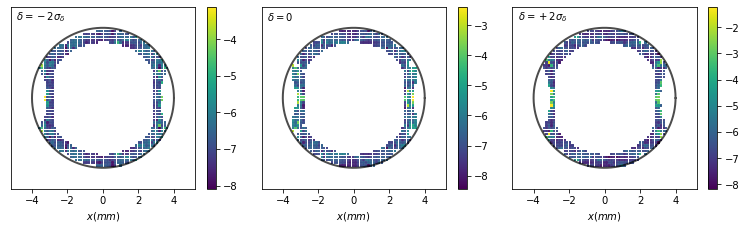

In [24]:
txt = [r'$\delta=-2\sigma_{\delta}$',r'$\delta=0$',r'$\delta=+2\sigma_{\delta}$']
fig = plt.figure(figsize=[4+3.3+3.3,3.3])
for i in range(3):
    plt.subplot(1,3,i+1)
    d = diff[i]
    x = pTest[indx[i],0]
    y = pTest[indx[i],2]
    f1=plt.scatter(x*1e3,y*1e3,c=d,s=1.6,marker='s')
    plt.scatter(x*1e3,-y*1e3,c=d,s=1.6,marker='s')
    plt.plot(ap1_x*c*1e3,ap1_y*s*1e3,alpha=0.7,c='k',lw=2)
    plt.xlim(-ap1_x*1.3*1e3,ap1_x*1.3*1e3)
    plt.ylim(-ap1_y*1.3*1e3,ap1_y*1.3*1e3)
    plt.xlabel('$x (mm)$')
    if j==0:
        plt.ylabel('$y (mm)$')
    else:
        plt.yticks([])
    plt.text(-4.9,6.1,txt[i])
    plt.colorbar(f1)
plt.tight_layout()
# plt.savefig('DA_'+deco+'_wAperture_T'+str(nturn)+'.png',dpi=180)

In [25]:
diffSum0 = np.array([np.sum(diff[i]) for i in range(3)]) 
diffSum1 = diffSum0+ np.array([np.max(diff[i])*(npt-len(indx[i])) for i in range(3)])
diffSum0, diffSum1

(array([-2125.73579182, -2142.69385663, -1962.96716391]),
 array([-2325.06044091, -2281.34023145, -2054.26135415]))

In [26]:
[len(indx[i]) for i in range(3)]

[316, 322, 305]